1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
​
2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)
​
6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import os

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

#### 1-3

In [6]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [7]:
data_w=data.resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [8]:
def split_data(data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

C:\Users\stroganov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


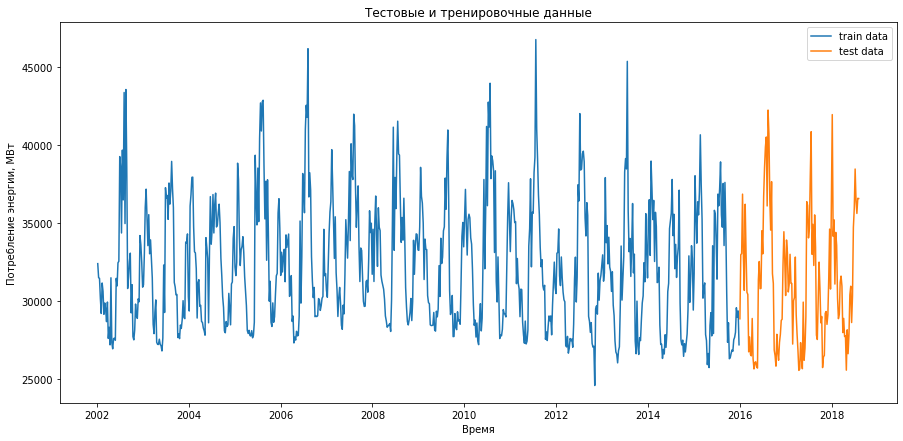

In [9]:
train, test = split_data(data_w, '01-01-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [15]:
h=1
X_train_1 = train.iloc[:-h,:]
Y_train_1 = train[train.columns[0]].values[h:]
X_test_1 = test.iloc[:-h,:]
Y_test_1 = test[test.columns[0]].values[h:]

In [16]:
h=4
X_train_4 = train.iloc[:-h,:]
Y_train_4 = train[train.columns[0]].values[h:]
X_test_4 = test.iloc[:-h,:]
Y_test_4 = test[test.columns[0]].values[h:]

Расчет для h=1

Определение оптимальных параметров для расчета модели

In [17]:
def report(results, n_top=40):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train_1, Y_train_1)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.679 (std: 0.041)
Parameters: {'n_estimators': 400, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.672 (std: 0.043)
Parameters: {'n_estimators': 500, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.650 (std: 0.038)
Parameters: {'n_estimators': 300, 'max_depth': 5}

Model with rank: 4
Mean validation score: 0.647 (std: 0.040)
Parameters: {'n_estimators': 1000, 'max_depth': 5}

Model with rank: 5
Mean validation score: 0.640 (std: 0.034)
Parameters: {'n_estimators': 1200, 'max_depth': 3}

Model with rank: 6
Mean validation score: 0.542 (std: 0.052)
Parameters: {'n_estimators': 1000, 'max_depth': 10}

Model with rank: 7
Mean validation score: 0.540 (std: 0.054)
Parameters: {'n_estimators': 300, 'max_depth': 10}

Model with rank: 8
Mean validation score: 0.445 (std: 0.075)
Parameters: {'n_estimators': 1200, 'max_depth': 14}

Model with rank: 9
Mean validation score: 0.443 (std: 0.074)
Parameters: {'n_estimators': 400, 'm

In [18]:
model_data_1 = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=1200)

In [19]:
model_data_1.fit( X_train_1, Y_train_1 )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1200, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
Y_test_pred_1 = model_data_1.predict(X_test_1)

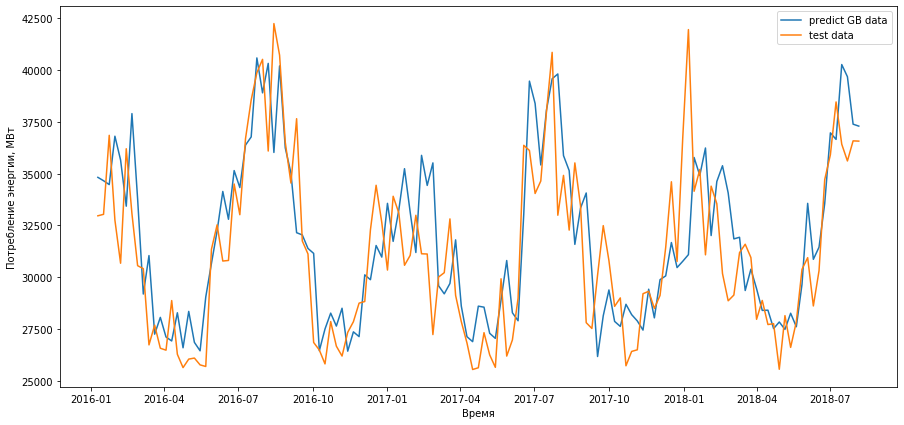

In [30]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:],Y_test_pred_1, label='predict GB data' )
plt.plot(test.index[1:],Y_test_1, label='test data')

plt.legend()
plt.show()

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
er_1_mape = mean_absolute_percentage_error(Y_test_1,Y_test_pred_1)

print('ошибка градиентного бустинга MAPE :  ', er_1_mape,'%')

ошибка градиентного бустинга MAPE :   6.78906525111053 %


In [33]:
er_1_mse = mean_squared_error(Y_test_1, Y_test_pred_1) 
er_1_mae = mean_absolute_error(Y_test_1, Y_test_pred_1) 
er_1_r2 = r2_score(Y_test_1, Y_test_pred_1)

print('ошибка mse :  ', er_1_mse,'\nошибка mae  :  ', er_1_mae,'\nоценка R2 :  ', er_1_r2)

ошибка mse :   7848575.599313216 
ошибка mae  :   2121.018474376039 
оценка R2 :   0.5267827001318985


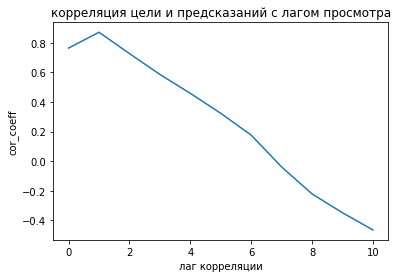

In [34]:
lag=10
p_cor=[np.corrcoef(Y_test_1, Y_test_pred_1)[1,0]]
for i in range(lag):
    c=np.corrcoef( Y_test_1[:-(i+1)], Y_test_pred_1[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

In [35]:
def report(results, n_top=40):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train_4, Y_train_4)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.625 (std: 0.048)
Parameters: {'n_estimators': 200, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.623 (std: 0.050)
Parameters: {'n_estimators': 500, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.617 (std: 0.054)
Parameters: {'n_estimators': 1000, 'max_depth': 2}

Model with rank: 4
Mean validation score: 0.601 (std: 0.062)
Parameters: {'n_estimators': 500, 'max_depth': 3}

Model with rank: 5
Mean validation score: 0.578 (std: 0.052)
Parameters: {'n_estimators': 500, 'max_depth': 5}

Model with rank: 6
Mean validation score: 0.577 (std: 0.056)
Parameters: {'n_estimators': 1500, 'max_depth': 5}

Model with rank: 7
Mean validation score: 0.575 (std: 0.053)
Parameters: {'n_estimators': 1200, 'max_depth': 5}

Model with rank: 8
Mean validation score: 0.493 (std: 0.096)
Parameters: {'n_estimators': 100, 'max_depth': 10}

Model with rank: 9
Mean validation score: 0.398 (std: 0.117)
Parameters: {'n_estimators': 1000, 'max

Расчет для h=4

In [36]:
model_data_4 = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=200)

In [37]:
model_data_4.fit(X_train_4, Y_train_4 )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
Y_test_pred_4 = model_data_4.predict(X_test_4)

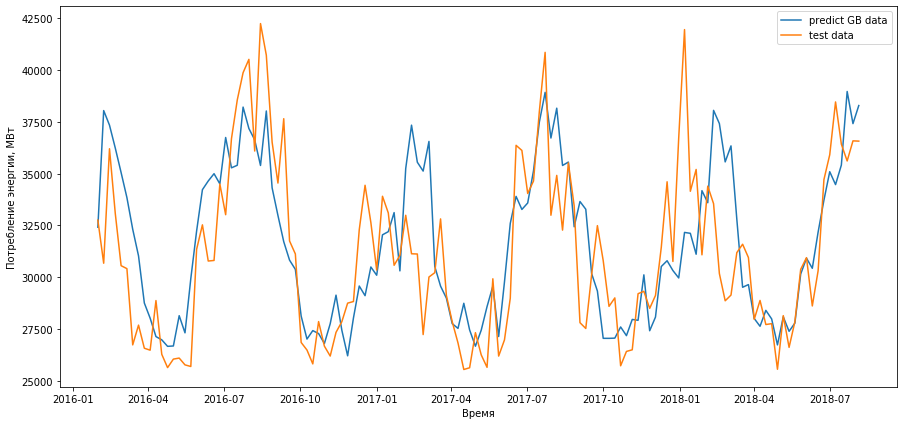

In [39]:
plt.figure(figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[4:],Y_test_pred_4, label='predict GB data' )
plt.plot(test.index[4:],Y_test_4, label='test data')

plt.legend()
plt.show()

In [40]:
er_4_mape = mean_absolute_percentage_error(Y_test_4,Y_test_pred_4)

print('ошибка градиентного бустинга MAPE :  ', er_4_mape,'%')

ошибка градиентного бустинга MAPE :   7.274247193000067 %


In [41]:
er_4_mse = mean_squared_error(Y_test_4, Y_test_pred_4) 
er_4_mae = mean_absolute_error(Y_test_4, Y_test_pred_4) 
er_4_r2 = r2_score(Y_test_4, Y_test_pred_4)

print('ошибка mse :  ', er_4_mse,'\nошибка mae  :  ', er_4_mae,'\nоценка R2 :  ', er_4_r2)

ошибка mse :   9228587.085618703 
ошибка mae  :   2275.8087842630243 
оценка R2 :   0.4462729270486374


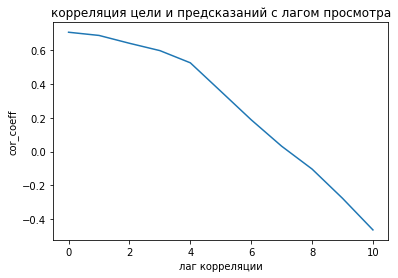

In [42]:
lag=10
p_cor=[np.corrcoef( Y_test_4, Y_test_pred_4)[1,0]]
for i in range(lag):
    c=np.corrcoef( Y_test_4[:-(i+1)], Y_test_pred_4[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

#### 4

Возьмем срез последних 100 значений

In [60]:
X_test_100 = X_test_4[-100:].copy()
y_test_100 = Y_test_4[-100:].copy()

In [61]:
X_test_100 = X_test_100.reset_index(drop=True)

In [62]:
y_predict_4 = model_data_4.predict(X_test_100[0:3])

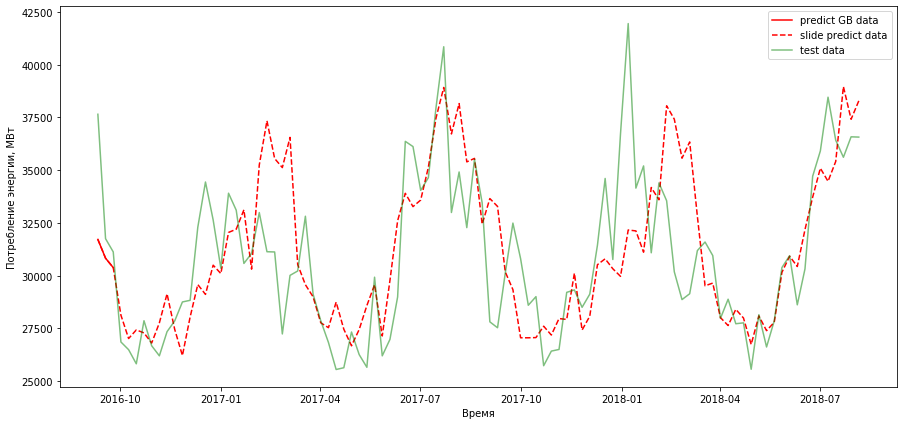

In [72]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[36:39],y_predict_4, 'r',label='predict GB data' )
plt.plot(test.index[-100:],Y_test_pred_4[-100:], '--r',label='slide predict data')
plt.plot(test.index[-100:],Y_test_4[-100:], 'g',label='test data', alpha=0.5)
plt.legend()
plt.show()

In [73]:
er_4_mape = mean_absolute_percentage_error(Y_test_4[0:3],y_predict_4)

print('ошибка градиентного бустинга MAPE :  ', er_4_mape,'%')

ошибка градиентного бустинга MAPE :   6.581582173120533 %


In [74]:
er_4_mse = mean_squared_error(Y_test_4[0:3],y_predict_4)
er_4_mae = mean_absolute_error(Y_test_4[0:3],y_predict_4)
er_4_r2 = r2_score(Y_test_4[0:3],y_predict_4)

print('ошибка mse :  ', er_4_mse,'\nошибка mae  :  ', er_4_mae,'\nоценка R2 :  ', er_4_r2)

ошибка mse :   11664314.62684974 
ошибка mae  :   2337.189187053238 
оценка R2 :   -1.2476400733245372


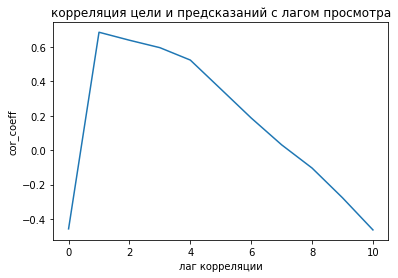

In [75]:
lag=10
p_cor=[np.corrcoef(Y_test_4[0:3],y_predict_4)[1,0]]
for i in range(lag):
    c=np.corrcoef(Y_test_4[:-(i+1)], Y_test_pred_4[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

Значения метрик получились хуже чем у обычного прогноза

#### 5

1-10

In [108]:
y_predict_10 = model_data_4.predict(X_test_100[0:10])

In [109]:
er_10_mape = mean_absolute_percentage_error(Y_test_4[32:42],y_predict_10)

print('ошибка градиентного бустинга MAPE :  ', er_10_mape,'%')

ошибка градиентного бустинга MAPE :   4.910265465963979 %


In [110]:
er_10_mse = mean_squared_error(Y_test_4[32:42],y_predict_10)
er_10_mae = mean_absolute_error(Y_test_4[32:42],y_predict_10)
er_10_r2 = r2_score(Y_test_4[32:42],y_predict_10)

print('ошибка mse :  ', er_10_mse,'\nошибка mae  :  ', er_10_mae,'\nоценка R2 :  ', er_10_r2)

ошибка mse :   4712121.947206326 
ошибка mae  :   1507.4110152760754 
оценка R2 :   0.622364286475193


11-20

In [111]:
y_predict_20 = model_data_4.predict(X_test_100[11:20])

In [112]:
er_20_mape = mean_absolute_percentage_error(Y_test_4[42:51],y_predict_20)

print('ошибка градиентного бустинга MAPE :  ', er_20_mape,'%')

ошибка градиентного бустинга MAPE :   5.641046396489605 %


In [113]:
er_20_mse = mean_squared_error(Y_test_4[42:51],y_predict_20)
er_20_mae = mean_absolute_error(Y_test_4[42:51],y_predict_20)
er_20_r2 = r2_score(Y_test_4[42:51],y_predict_20)

print('ошибка mse :  ', er_20_mse,'\nошибка mae  :  ', er_20_mae,'\nоценка R2 :  ', er_20_r2)

ошибка mse :   4633439.273875272 
ошибка mae  :   1799.9463434345769 
оценка R2 :   0.13202033579968253


21-30

In [114]:
y_predict_30 = model_data_4.predict(X_test_100[21:30])

In [115]:
er_30_mape = mean_absolute_percentage_error(Y_test_4[52:61],y_predict_30)

print('ошибка градиентного бустинга MAPE :  ', er_30_mape,'%')

ошибка градиентного бустинга MAPE :   12.014206548869073 %


In [116]:
er_30_mse = mean_squared_error(Y_test_4[52:61],y_predict_30)
er_30_mae = mean_absolute_error(Y_test_4[52:61],y_predict_30)
er_30_r2 = r2_score(Y_test_4[52:61],y_predict_30)

print('ошибка mse :  ', er_30_mse,'\nошибка mae  :  ', er_30_mae,'\nоценка R2 :  ', er_30_r2)

ошибка mse :   19559572.426951125 
ошибка mae  :   3625.032800432596 
оценка R2 :   -5.93651890622778


31-40

In [117]:
y_predict_40 = model_data_4.predict(X_test_100[31:40])

In [118]:
er_40_mape = mean_absolute_percentage_error(Y_test_4[62:71],y_predict_40)

print('ошибка градиентного бустинга MAPE :  ', er_40_mape,'%')

ошибка градиентного бустинга MAPE :   9.67306174152612 %


In [119]:
er_40_mse = mean_squared_error(Y_test_4[62:71],y_predict_40)
er_40_mae = mean_absolute_error(Y_test_4[62:71],y_predict_40)
er_40_r2 = r2_score(Y_test_4[62:71],y_predict_40)

print('ошибка mse :  ', er_40_mse,'\nошибка mae  :  ', er_40_mae,'\nоценка R2 :  ', er_40_r2)

ошибка mse :   9039847.826059464 
ошибка mae  :   2579.6150438002096 
оценка R2 :   -4.458549937281963


41-50

In [120]:
y_predict_50 = model_data_4.predict(X_test_100[41:50])

In [121]:
er_50_mape = mean_absolute_percentage_error(Y_test_4[72:81],y_predict_50)

print('ошибка градиентного бустинга MAPE :  ', er_50_mape,'%')

ошибка градиентного бустинга MAPE :   7.414164134407682 %


In [122]:
er_50_mse = mean_squared_error(Y_test_4[72:81],y_predict_50)
er_50_mae = mean_absolute_error(Y_test_4[72:81],y_predict_50)
er_50_r2 = r2_score(Y_test_4[72:81],y_predict_50)

print('ошибка mse :  ', er_50_mse,'\nошибка mae  :  ', er_50_mae,'\nоценка R2 :  ', er_50_r2)

ошибка mse :   8990719.777884863 
ошибка mae  :   2618.122982574456 
оценка R2 :   -0.4505501325337211


51-60

In [123]:
y_predict_60 = model_data_4.predict(X_test_100[51:60])

In [124]:
er_60_mape = mean_absolute_percentage_error(Y_test_4[82:91],y_predict_60)

print('ошибка градиентного бустинга MAPE :  ', er_60_mape,'%')

ошибка градиентного бустинга MAPE :   8.584076433443558 %


In [125]:
er_60_mse = mean_squared_error(Y_test_4[82:91],y_predict_60)
er_60_mae = mean_absolute_error(Y_test_4[82:91],y_predict_60)
er_60_r2 = r2_score(Y_test_4[82:91],y_predict_60)

print('ошибка mse :  ', er_60_mse,'\nошибка mae  :  ', er_60_mae,'\nоценка R2 :  ', er_60_r2)

ошибка mse :   9745961.067527646 
ошибка mae  :   2520.110964395754 
оценка R2 :   -0.8029152812847047


61-70

In [126]:
y_predict_70 = model_data_4.predict(X_test_100[61:70])

In [127]:
er_70_mape = mean_absolute_percentage_error(Y_test_4[92:101],y_predict_70)

print('ошибка градиентного бустинга MAPE :  ', er_70_mape,'%')

ошибка градиентного бустинга MAPE :   5.634315237981254 %


In [128]:
er_70_mse = mean_squared_error(Y_test_4[92:101],y_predict_70)
er_70_mae = mean_absolute_error(Y_test_4[92:101],y_predict_70)
er_70_r2 = r2_score(Y_test_4[92:101],y_predict_70)

print('ошибка mse :  ', er_70_mse,'\nошибка mae  :  ', er_70_mae,'\nоценка R2 :  ', er_70_r2)

ошибка mse :   5427463.827062387 
ошибка mae  :   1816.4372323080825 
оценка R2 :   0.39915355338192393


71-80

In [129]:
y_predict_80 = model_data_4.predict(X_test_100[71:80])

In [130]:
er_80_mape = mean_absolute_percentage_error(Y_test_4[102:111],y_predict_80)

print('ошибка градиентного бустинга MAPE :  ', er_80_mape,'%')

ошибка градиентного бустинга MAPE :   11.529333454412233 %


In [131]:
er_80_mse = mean_squared_error(Y_test_4[102:111],y_predict_80)
er_80_mae = mean_absolute_error(Y_test_4[102:111],y_predict_80)
er_80_r2 = r2_score(Y_test_4[102:111],y_predict_80)

print('ошибка mse :  ', er_80_mse,'\nошибка mae  :  ', er_80_mae,'\nоценка R2 :  ', er_80_r2)

ошибка mse :   16236363.006668381 
ошибка mae  :   3589.6052552107353 
оценка R2 :   -2.1873574173348445


81-90

In [132]:
y_predict_90 = model_data_4.predict(X_test_100[81:90])

In [133]:
er_90_mape = mean_absolute_percentage_error(Y_test_4[112:121],y_predict_90)

print('ошибка градиентного бустинга MAPE :  ', er_90_mape,'%')

ошибка градиентного бустинга MAPE :   4.7002669879411885 %


In [134]:
er_90_mse = mean_squared_error(Y_test_4[112:121],y_predict_90)
er_90_mae = mean_absolute_error(Y_test_4[112:121],y_predict_90)
er_90_r2 = r2_score(Y_test_4[112:121],y_predict_90)

print('ошибка mse :  ', er_90_mse,'\nошибка mae  :  ', er_90_mae,'\nоценка R2 :  ', er_90_r2)

ошибка mse :   2641545.9831326236 
ошибка mae  :   1313.0475152872723 
оценка R2 :   -0.35797976174094415


91-100

In [135]:
y_predict_100 = model_data_4.predict(X_test_100[91:100])

In [137]:
er_100_mape = mean_absolute_percentage_error(Y_test_4[122:131],y_predict_100)

print('ошибка градиентного бустинга MAPE :  ', er_100_mape,'%')

ошибка градиентного бустинга MAPE :   6.120690714908691 %


In [138]:
er_100_mse = mean_squared_error(Y_test_4[122:131],y_predict_100)
er_100_mae = mean_absolute_error(Y_test_4[122:131],y_predict_100)
er_100_r2 = r2_score(Y_test_4[122:131],y_predict_100)

print('ошибка mse :  ', er_100_mse,'\nошибка mae  :  ', er_100_mae,'\nоценка R2 :  ', er_100_r2)

ошибка mse :   5411064.401709232 
ошибка mae  :   2044.7605875487943 
оценка R2 :   0.46359846354973233


При различных интервалах ошибка меняется случайно

В зависимости от выбранного периода можно эффективно использовать различные методы прогноза